In [1]:
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
# from langchain.chat_models import ChatOpenAI
from langchain_community.chat_models import ChatOllama
from langchain_community import embeddings

# from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [7]:
output_path = "./new_ppt_ms_images"

In [3]:
raw_pdf_elements = partition_pdf(
    filename=r"C:\Users\RAHUL\Desktop\chatbot_new\chatbot\multiple_sclerosis_ppt_pdf.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=7500,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir=output_path,
)

This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

In [4]:
len(raw_pdf_elements)

108

In [6]:
len(raw_pdf_elements[0].text)

1666

In [9]:
from tqdm import tqdm
text_elements = []
table_elements = []

text_summaries = []
table_summaries = []

summary_prompt = """
Summarize the following {element_type}:
{element} 
"""
summary_chain = LLMChain(
    llm=ChatOllama(model="mistral",temperature=0),
    prompt=PromptTemplate.from_template(summary_prompt)
)

for e in tqdm(raw_pdf_elements):
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'text', 'element': e})
        text_summaries.append(summary)

    elif 'Table' in repr(e):
        table_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'table', 'element': e})
        table_summaries.append(summary)
image_elements = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')
for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)

import os
import ollama
from tqdm import tqdm
import base64
from PIL import Image
from io import BytesIO

# Initialize an empty list to store the results
img_summaries = []

# Iterate over all image strings in the list with a tqdm progress bar
for image_string in tqdm(image_elements, desc="Processing images"):
    # Decode the image string using utf-8 encoders
    img_data = base64.b64decode(image_string)
    img = Image.open(BytesIO(img_data))
    
    # Convert the image to RGB
    img_rgb = img.convert('RGB')
    
    # Save the image to a temporary file
    img_rgb.save("temp.jpg")
    
    # Call the chat function with the image file
    res = ollama.chat(
        model="llava",
        messages=[
            {
                'role':'user',
                'content':'now im gonna give you an image related to multiple sclerosis so describe this image and also extract and understand the text labels on the image as much as possible and then describe the image in the pure medical term',
                'images':["temp.jpg"]
            }
        ]
    )
    
    # Append the result to the image_summary list
    img_summaries.append(res['message']['content'])


# Print the image_summary list
print(img_summaries)
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(table_elements, table_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'table',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, img_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=embeddings.OllamaEmbeddings(model='nomic-embed-text'))
vectorstore.save_local("new_ppt_MS_FAISS")

Processing images: 100%|██████████| 152/152 [2:39:21<00:00, 62.91s/it] 


[' The image appears to be a slide from a presentation, possibly related to healthcare or medical research. It is a graphical representation of data with text labels that include information about the study and its results.\n\nOn the left side, there\'s a title that reads "Opera II," which might indicate this slide pertains to Opera II. Below that, we see two main components:\n\n1. A pie chart at the top left corner of the image, divided into four segments, labeled as "Effectivity," "Safety," "Durability," and "Tolerability." The percentages for each segment are not provided in the visible part of the image.\n\n2. Below the pie chart, there is a timeline graphic with two main vertical bars:\n   - A taller vertical bar labeled "CICUIT START" with a duration marked from 0 to 132 weeks, which suggests the follow-up period after treatment start.\n   - A shorter vertical bar labeled "CICUIT END," indicating the end of the follow-up period.\n\nOn the right side, there is text that seems to p

In [9]:
len(documents)

706

In [10]:
documents[0]

Document(page_content=' The text summarizes various organizations and services based in New Delhi, India. MSSI Multiple Sclerosis Society of India in Delhi has a managing committee led by Bipasha Gupta, Mridula Murgai, Prabal Malaker, Meenakshi Bhujwala, Ragini Mathur, Meera Pinky Hora, Praveen Khetarpal, and Ameeta Gupta. The team has been serving MS persons and their families across multiple states for over 34 years. They are affiliated with the Multiple Sclerosis International Federation (MSIF) and have a dedicated admin and field team including Shashi Verma, Raj Kumar, Shagufta Fatima, and Raji Vijayen.\n\nAirtel is offering Wi-Fi plans starting at $499 with Xstream Fiber in Delhi. Powerica is a leading authorized GOEM Cummins power generation company that offers silent diesel generators ranging from 7.5 kVA to 3750 kVA. Zaza Stay is a bed and breakfast located centrally in New Delhi, perfect for both business and pleasure.\n\nThe MSSI team expresses their gratitude towards the lov

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter_rec = RecursiveCharacterTextSplitter(
    chunk_size = 3800,
    chunk_overlap  = 400,
    # length_function = len,
)
texts = text_splitter_rec.split_documents(documents)

rec_vectorstore = FAISS.from_documents(documents=texts, embedding=embeddings.OllamaEmbeddings(model='nomic-embed-text'))
rec_vectorstore.save_local("new_rec_pdf_MS_FAISS")

In [19]:
# from langchain.text_splitter import RecursiveCharacterTextSplitter
# text_splitter_rec_300 = RecursiveCharacterTextSplitter(
#     chunk_size = 7500,
#     chunk_overlap  = 300,
#     # length_function = len,
# )
# texts_300 = text_splitter_rec_300.split_documents(documents)

# rec_vectorstore = FAISS.from_documents(documents=texts_300, embedding=embeddings.OllamaEmbeddings(model='nomic-embed-text'))
# rec_vectorstore.save_local("rec_MS_FAISS_300")

In [ ]:
len(documents)

In [1]:
# db1 = FAISS.load_local("ppt_MS_FAISS", embeddings,allow_dangerous_deserialization=True)

NameError: name 'FAISS' is not defined

In [7]:
# db2 = FAISS.load_local("multiple_Scelarosis_images_faiss", embeddings,allow_dangerous_deserialization=True)

In [8]:
# db1.merge_from(db2)

In [9]:
# db1.save_local("faiss_multiple_Scelarosis")

In [2]:
embeddings = embeddings.OllamaEmbeddings(model='nomic-embed-text')

In [3]:
db1 = FAISS.load_local("pdf_MS_FAISS", embeddings,allow_dangerous_deserialization=True)

In [4]:
db2 = FAISS.load_local("ppt_MS_FAISS", embeddings,allow_dangerous_deserialization=True)

In [5]:
db1.merge_from(db2)

In [6]:
db1.save_local("merged_pdf_ppt_Faiss")

: 

In [3]:
db = FAISS.load_local("new_rec_pdf_MS_FAISS", embeddings,allow_dangerous_deserialization=True)

In [4]:
prompt_template = """
You are a data scientist and an expert in analyzing images and tables and text.
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much as detailed possible.
Answer:
"""

In [5]:
qa_chain = LLMChain(llm=ChatOllama(model="mistral", temperature=0),
                        prompt=PromptTemplate.from_template(prompt_template))

In [6]:
db.similarity_search("what are the common symtoms of MS")

[Document(page_content='MS (Multiple Sclerosis) is a chronic, neuroinflammatory, and neurodegenerative disease affecting the central nervous system. It was first identified clinically by Jean-Martin Charcot in 1868, who described symptoms such as nystagmus, intention tremor, and scanning speech. MS symptoms are unpredictable and can include mobility impairment (90%), sensory problems (85%), fatigue (80%), bladder dysfunction (80%), walking difficulties (50-70%), pain (67%), cognitive changes (50%), spasticity (44-84%), speech problems (25-40%), respiratory problems (20%), hearing loss (6%), and seizures (2-5%). Less common symptoms include secondary and tertiary complications such as urinary tract infections, decreased bone density, muscle tone loss, pressure sores, and social, vocational, and psychological complications.', metadata={'id': 'f74c4c10-7704-4d56-a8e4-0aeecb37a598', 'type': 'text', 'original_content': 'MS is a chronic, neuroinflammatory, neurodegenerative disease of the CN

In [7]:

def answer(question):
    relevant_docs = db.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images

In [ ]:
result, relevant_images = answer("what are the Special warnings and precautions for use of ocrevus")
print(result)

In [34]:
result, relevant_images = answer("what are the Special warnings and precautions for use of ocrevus")
print(result)

 The special warnings and precautions for use of Ocrevus (ocrelizumab) include:

1. Infusion-related reactions (IRR): IRRs can occur within 24 hours of infusion, more frequently during the first infusion. Symptoms may be clinically indistinguishable from hypersensitivity reactions. The risk characterization remains unchanged.
2. Hypersensitivity reactions: These reactions may not typically occur during the first infusion.
3. Infection: Ocrelizumab must be delayed in patients with an active infection until the infection has resolved. John Cunningham virus infection resulting in PML and hepatitis B virus reactivation have been observed in patients treated with anti-CD20 antibodies, including ocrelizumab.
4. Malignancies: An increased number of malignancies was observed in trials with ocrelizumab compared with control groups, but the incidence was within the background rate expected for MS. Patients should follow standard breast cancer and bowel cancer screening per local guidelines.
5. S

In [8]:
result, relevant_images = answer("give me an example of affected area for multiple sclerosis")
print(result)

c:\Users\RAHUL\Desktop\chatbot_new\chatbot\multimodel\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


 Multiple sclerosis (MS) primarily affects the central nervous system (CNS), which includes the brain and spinal cord. In MS, the immune system mistakenly attacks the protective covering of nerve fibers, called myelin sheaths, leading to communication problems between the brain and the rest of the body.

One common area affected by MS is the optic nerve, which is responsible for transmitting visual information from the eyes to the brain. Demyelination in this area can result in vision loss, blurred vision, or other visual disturbances. This is often the initial symptom of MS, and it's referred to as the opticospinal variant of the disease.

Another area frequently affected by MS is the spinal cord. Damage to the myelin sheaths in the spinal cord can cause a range of symptoms, including numbness or weakness in the extremities, difficulty walking, and bladder issues. These symptoms are collectively referred to as the spinal cord dysfunction variant of MS.

Additionally, MS can affect var

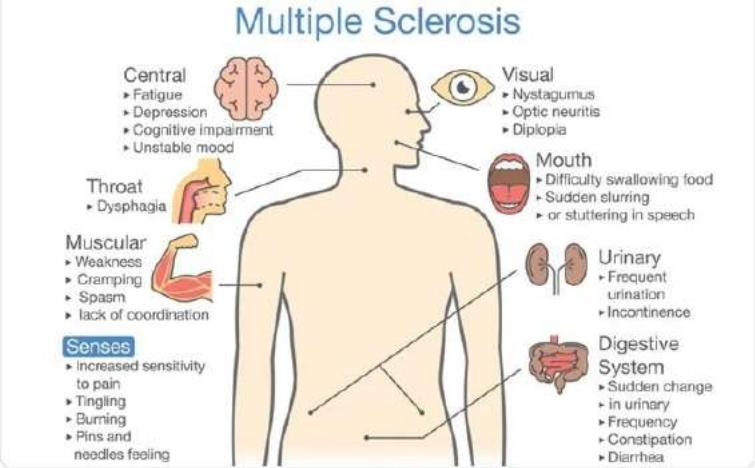

In [13]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

pdf_ms_faiss

In [16]:
result, relevant_images = answer("what causes exacerbations?")
print(result)

 Exact causes of MS exacerbations are not fully understood, but several factors are believed to contribute to their occurrence. These include:

1. Immune system dysfunction: MS is an autoimmune disease, and exacerbations may be triggered by the immune system attacking myelin sheaths in the central nervous system (CNS). Factors that can stimulate this immune response include viral or bacterial infections, stress, and certain environmental factors.
2. Environmental factors: Exposure to certain environmental factors, such as cold weather, smoking, and certain chemicals, can trigger MS exacerbations. Vitamin D deficiency is also considered a risk factor for MS exacerbations.
3. Infection: Viral or bacterial infections, particularly those that affect the respiratory system, have been linked to MS exacerbations. EBV and human herpes virus type 6 are two viruses that have been implicated in MS exacerbations.
4. Stress: Emotional stress can trigger MS exacerbations by activating the immune sys

rec_pdf_ms_Faiss

In [26]:
result, relevant_images = answer("what causes exacerbations?")
print(result)

 Exact causes of MS exacerbations are not fully understood, but several factors are believed to contribute to their occurrence. These include:

1. Immune system dysfunction: MS is an autoimmune disease, and exacerbations may be triggered by the immune system attacking myelin sheaths in the central nervous system (CNS). Factors that can stimulate this immune response include viral or bacterial infections, stress, and certain environmental factors.
2. Environmental factors: Exposure to certain environmental factors, such as cold weather, smoking, and certain chemicals, can trigger MS exacerbations. Vitamin D deficiency is also considered a risk factor for MS exacerbations.
3. Infection: Viral or bacterial infections, particularly those that affect the respiratory system, have been linked to MS exacerbations. EBV and human herpes virus type 6 are two viruses that have been implicated in MS exacerbations.
4. Stress: Emotional stress can trigger MS exacerbations by activating the immune sys

In [28]:
result, relevant_images = answer("how are exacerbations caused?")
print(result)

 Exacerbations or relapses in Multiple Sclerosis (MS) are thought to be caused by an acute inflammatory response in the central nervous system (CNS). This inflammation is believed to be triggered by various factors, including:

1. Autoimmune reactions: The immune system mistakenly attacks the myelin sheath that covers and protects nerve fibers in the CNS. This results in damage to the nerve fibers and disrupts communication between the brain and other parts of the body.
2. Environmental factors: Certain environmental factors, such as viral infections or exposure to certain chemicals, can trigger an immune response and lead to exacerbations. For example, Epstein-Barr virus (EBV) has been linked to MS relapses.
3. Genetic susceptibility: As mentioned earlier, there is a genetic component to MS, and some people may be more genetically predisposed to experiencing exacerbations. Specifically, certain HLA genes have been associated with an increased risk of MS and exacerbations.
4. Demyelina

In [17]:
result, relevant_images = answer("common symptoms of multiple sclerosis and example image of it?")
print(result)

 Multiple sclerosis (MS) is a chronic autoimmune disorder that affects the central nervous system (CNS). Common symptoms of MS can be categorized into cognitive and motor issues. Here are some common symptoms associated with MS, along with an example image:

**Common Symptoms of MS:**

1. **Fatigue or exhaustion:** MS can cause fatigue that is not relieved by rest. This can be caused by inflammation, immune reactions, or nerve damage.
2. **Numbness or tingling:** Patients with MS may experience numbness or tingling sensations in their hands and feet.
3. **Muscle weakness:** Muscle weakness, especially in the legs, is a common symptom of MS.
4. **Balance and coordination problems:** MS can cause balance and coordination issues that make it difficult to walk.
5. **Pain and itching:** Patients with MS may experience pain and itching sensations.
6. **Blurred vision or double vision:** Vision problems, such as blurred vision or double vision, are common in MS. These symptoms usually occur w

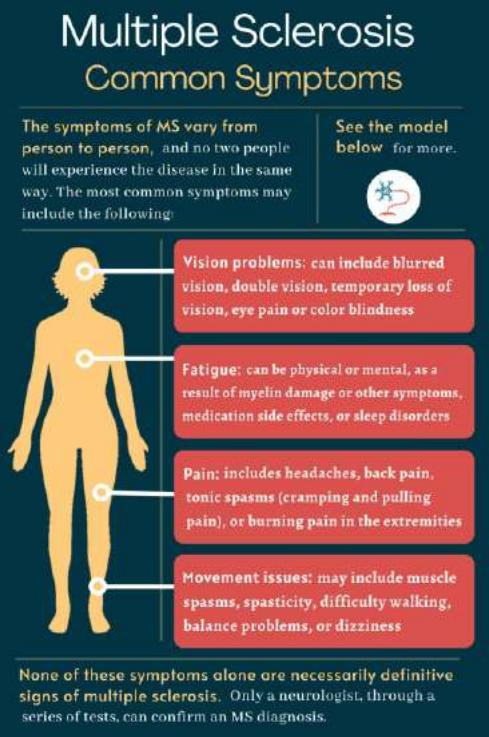

In [20]:
display.display(display.Image(base64.b64decode(relevant_images[2])))

# others

In [8]:
result, relevant_images = answer("tell me the patient eligibility criteria for oratorio and provide the image of it")
print(result)

c:\Users\RAHUL\Desktop\chatbot_new\chatbot\multimodel\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


 Based on the context provided in the image, the patient eligibility criteria for Oratorio can be summarized as follows:

Inclusion Criteria:
- Age between 18 and 55 years
- PPMS diagnosis (according to the 2005 McDonald criteria)

Exclusion Criteria:
- History of RRMS, SPMS or progressive relapsing MS
- Contraindications to MRI
- EDSS score lower than 3.0 or higher than 6.5
- Contraindications to/unacceptable side effects
- Score of 2 or more on pyramidal functions from oral or IV corticosteroids component of the KFSS
- Prior treatment with B-cell targeted therapies
- Disease duration less than 15 years for patients with EDSS scores of 5.0 or less, and less than 10 years for patients with EDSS scores greater than 5.0
- Prior treatment with other specific therapies
- Elevated IgG index or presence of 1 or more oligoclonal bands

Here's the image of the text overlay from the original context, which includes the eligibility criteria: [image] The image is a screenshot of an article or pre

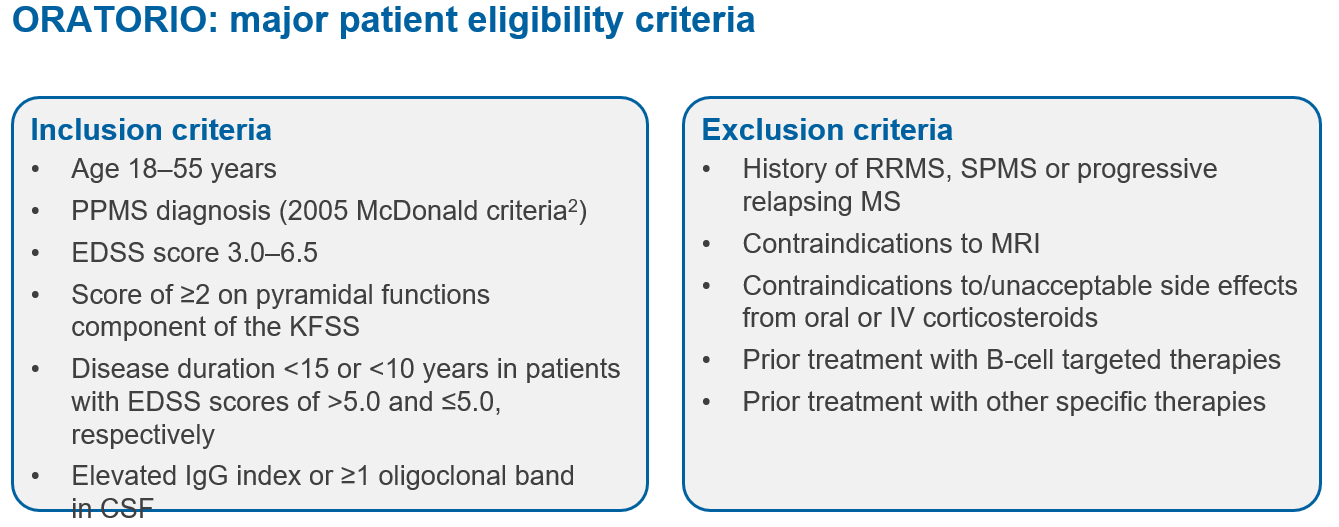

In [10]:
display.display(display.Image(base64.b64decode(relevant_images[1])))

In [11]:
result, relevant_images = answer("what is the role of mri")
print(result)

 The MRI (Magnetic Resonance Imaging) scan plays a crucial role in the diagnosis of Multiple Sclerosis (MS). It helps neurologists to identify lesions in the central nervous system (CNS), which is a key requirement for diagnosing MS according to the McDonald Criteria. These criteria state that there must be evidence of dissemination in space (DIS) and dissemination in time (DIT) for a diagnosis of MS.

Dissemination in space refers to the presence of lesions in distinct anatomical locations within the CNS, indicating a multifocal CNS process. Dissemination in time means the development or appearance of new CNS lesions over time, separate from the initial lesion(s). The MRI scan is used to assess these criteria by identifying multiple lesions in different areas of the brain and/or spinal cord, which can indicate MS.

Additionally, the MRI scan can help rule out other potential conditions with similar clinical presentations by providing valuable information about the nature and location 

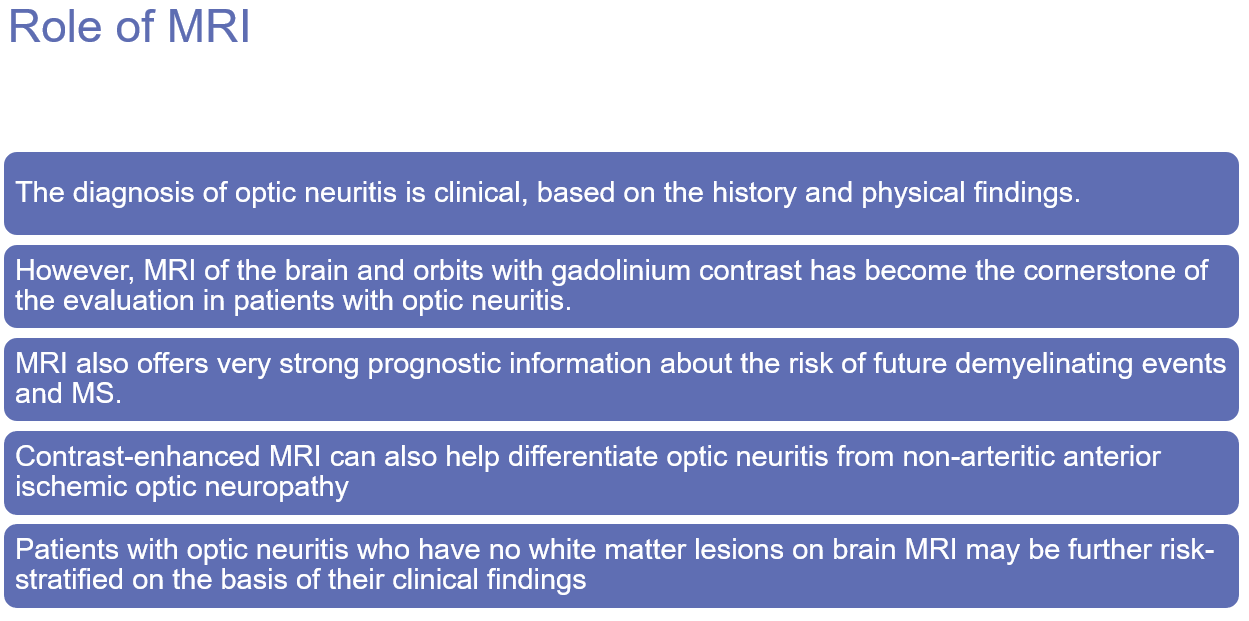

In [12]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [13]:
result, relevant_images = answer("ocreves pivotal trial outcome opera I & II in RMS pooled analysis")
print(result)

 The provided text and image appear to be from a medical report or presentation discussing the results of two clinical trials, OPERA I and OPERA II, which evaluated the efficacy and safety of ocrelizumab in patients with relapsing-remitting multiple sclerosis (RRMS). The pivotal trial outcome analysis pooled data from both studies to assess various secondary endpoints, including changes in T3 lesion volume and disability progression.

The image includes a bar graph comparing the change in T3 lesion volume and total gadolinium volume from baseline to week 13 for different intervention groups (P00, P200, Change to T3 LDH ON ESDS). The text mentions that most patients showed complete control of their disability progression as measured by no evidence of progression (NEP) and had low levels of disability accumulation. Safety results were consistent with the known ocrelizumab safety profile, with no new safety signals observed.

The high progression-free rate in ENSEMBLE was also mentioned, 

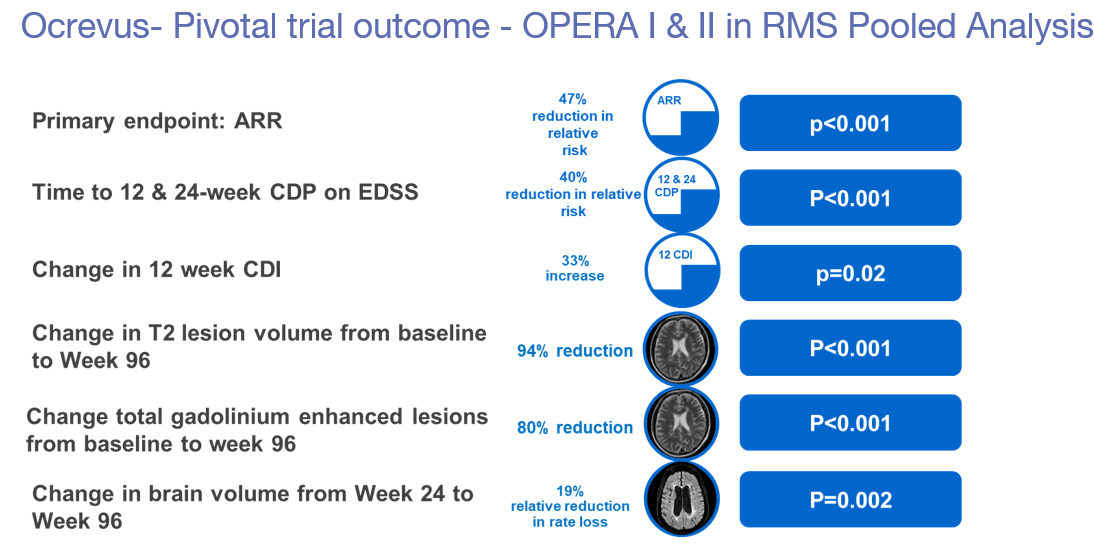

In [14]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [15]:
result, relevant_images = answer("48w-cdw-edss event rate")
print(result)

 The data provided does not directly address the 48W-CDW-EDSS event rate specifically. However, we can infer some information from the given data.

The bar chart in Panel 2 shows the number of CDPs (Common Disease Prevention) for two groups labeled "CROSS" and "4MW." The text is not clear enough to determine if these labels represent different time points or intervention groups. However, we can see that there are fewer CDPs in the "4MW" group compared to the "CROSS" group.

The line graph in Panel 1 shows two lines labeled "2W and 3W," which could imply a comparison between two different groups or treatments at 2 weeks (2W) and 3 weeks (3W). The text is not clear enough to determine if these labels represent the same CDP events as in the bar chart.

Based on this information, it's unclear what the exact 48W-CDW-EDSS event rate is for either group. However, we can infer that there are fewer CDPs in the "4MW" group compared to the "CROSS" group, suggesting a potential benefit of the inte

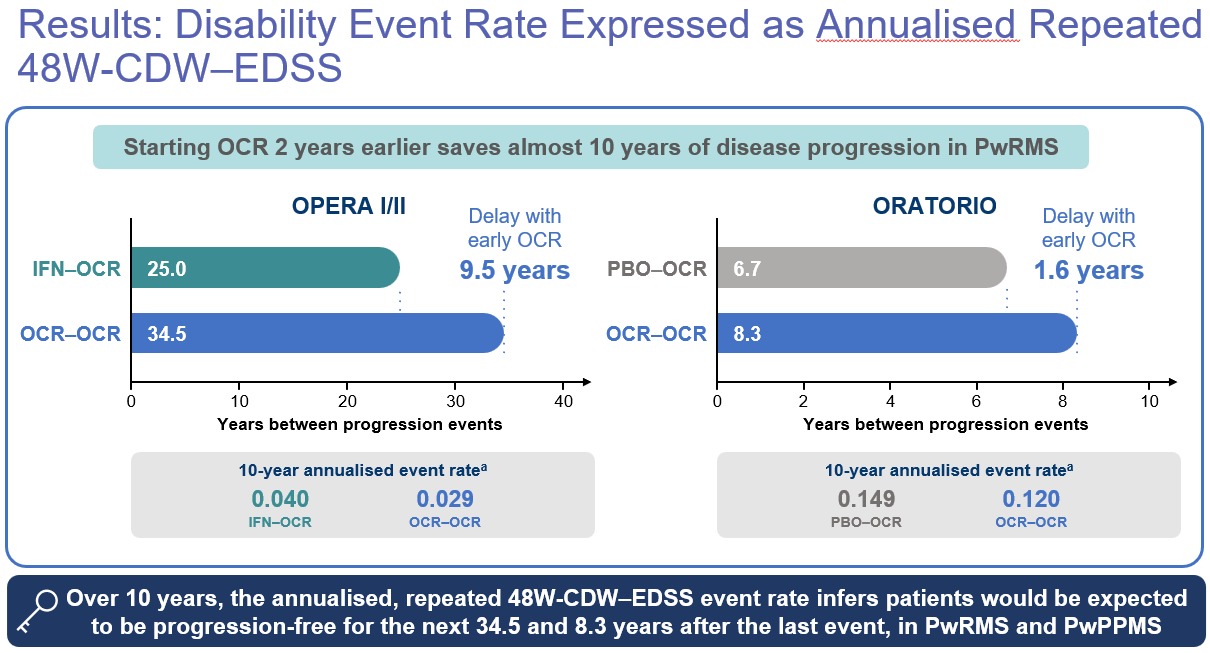

In [17]:
display.display(display.Image(base64.b64decode(relevant_images[1])))

In [18]:
result, relevant_images = answer("explain the patient population of rrms diagnosis")
print(result)

 The patient population for Relapsing-Remitting Multiple Sclerosis (RRMS) diagnosis refers to individuals who have been diagnosed with RRMS based on standardized diagnostic criteria. RRMS is characterized by distinct relapses followed by periods of remission, with no signs of disease progression during the remission phases.

The text and data provided indicate that approximately 78% of MS cases are diagnosed as RRMS in clinical settings, 19% in progressive settings, and 3% in heterogeneous settings. The mean age of this patient population is 32.4 years (SD 9.1), with a mean duration since MS symptom onset of 1.10 years (SD 0.84) and a mean duration since RRMS diagnosis of 0.36 years (SD 0.40). The mean Expanded Disability Status Scale (EDSS) score at baseline is 1.71 (SD 0.95).

The ITT (Intention-to-Treat) population for RRMS diagnosis consists of 678 patients, with relevant demographic and clinical information available. Factors influencing the diagnosis and treatment of RRMS include

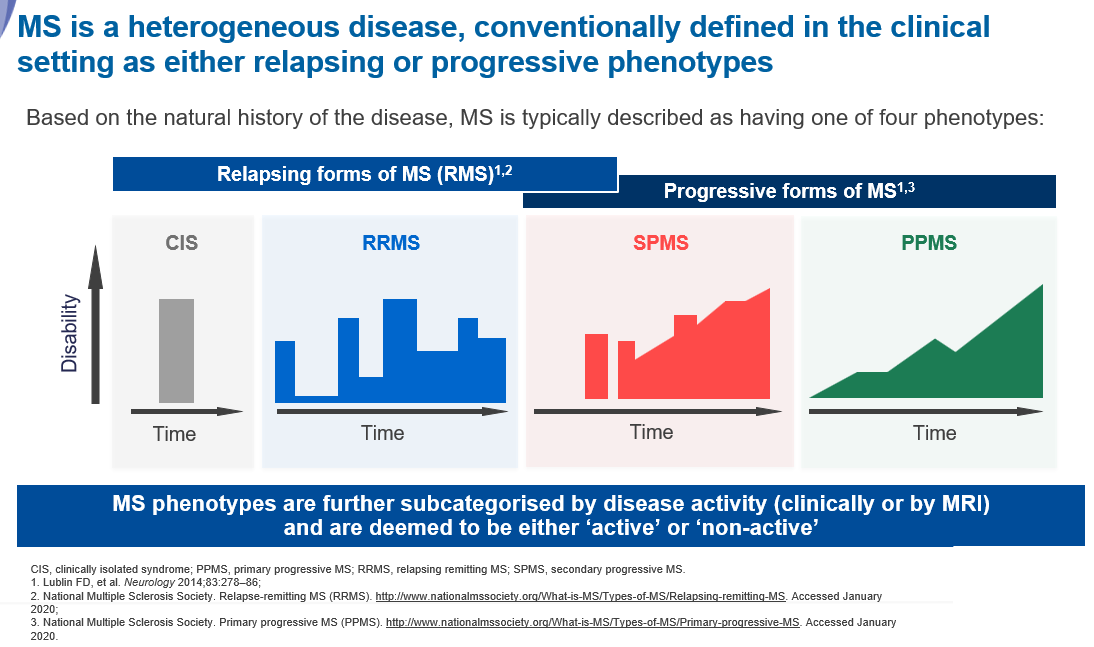

In [21]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [22]:
result, relevant_images = answer("what are the predictors for development of MS")
print(result)

 The predictors for the development of Multiple Sclerosis (MS) include several factors. Here are some of the known risk factors and associated symptoms or conditions:

1. Age of diagnosis: Younger age at diagnosis is associated with a higher risk of MS.
2. Sex: Females have a higher incidence of MS than males, but there is minimal sex bias in Primary Progressive MS (PPMS).
3. Features of MS: Symptoms such as fatigue and numbness are common in MS.
4. Stress levels: High stress levels may increase the risk of developing MS.
5. Anxiety disorders: A history of anxiety disorders might be a predictor for MS development.
6. Depression disorders: Depression is also associated with an increased risk of MS.
7. Autoimmune diseases: Having other autoimmune diseases increases the likelihood of developing MS.
8. Migraines or headaches: Some studies suggest that migraines or headaches might be a predictor for MS development.
9. Optic neuritis (ON): ON, an inflammation of the optic nerve, is a common 

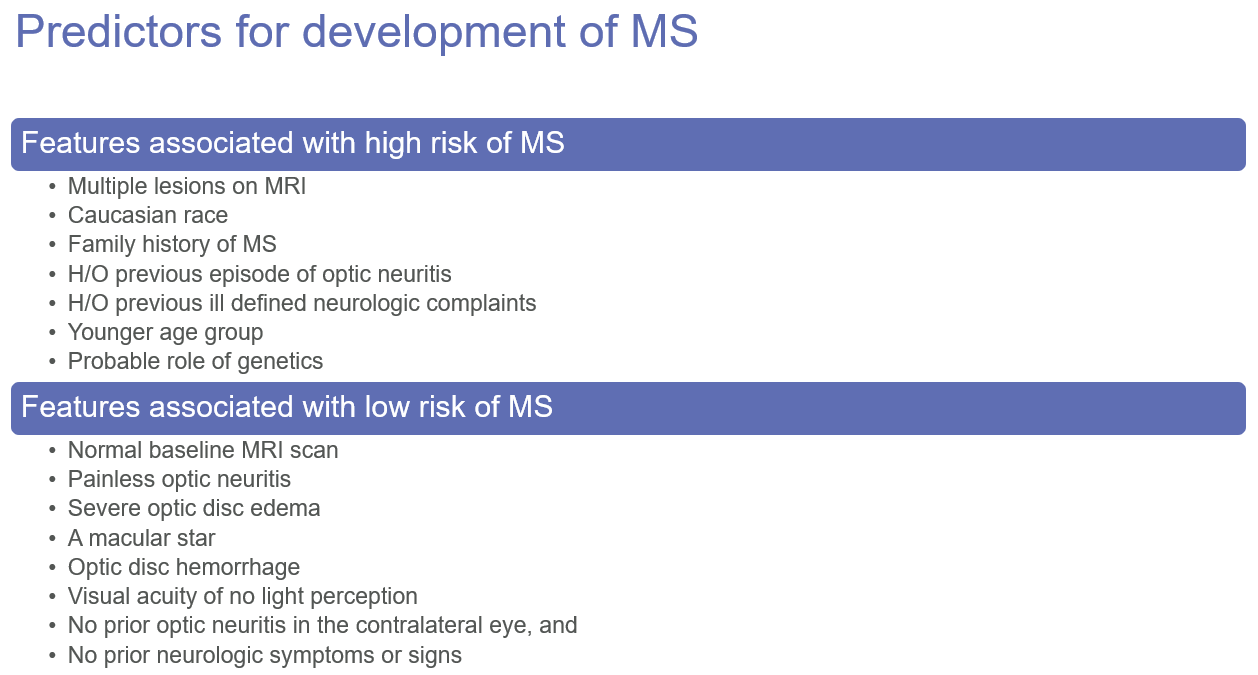

In [23]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [24]:
result, relevant_images = answer("adverse events and serious adverse events")
print(result)

 The text in the image discusses various risks and safety data related to Ocrevus (ocrelizumab), a treatment for multiple sclerosis (MS). Among the most frequently reported adverse events is infusion-related reactions (IRRs), which occur in 34.3% of patients, although the majority are of mild to moderate intensity and non-serious. The risk of IRRs is highest with the first infusion but decreases over subsequent doses.

Another important identified risk is infections, including nasopharyngitis, urinary tract infections (UTIs), influenza, and upper respiratory tract infections (URTIs). No opportunistic infections were confirmed with ocrelizumab, and the rate and type of infections remained consistent over 7 years. The most common serious infections were UTIs and pneumonia.

Another risk discussed is impaired response to vaccination. Ocrevus did not appear to affect the prior humoral immune response, but patients who were peripherally B-cell depleted while on treatment were able to mount 

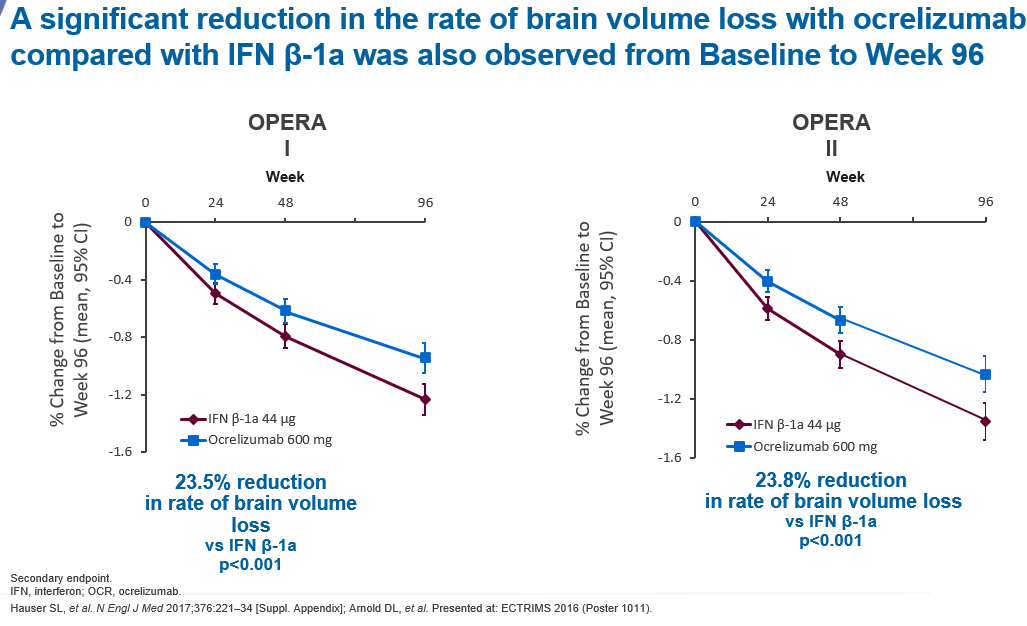

In [28]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [15]:
result, relevant_images = answer("brief about multiple sclerosis")
print(result)

c:\Users\RAHUL\Desktop\chatbot_new\chatbot\multimodel\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


 Multiple sclerosis (MS) is a chronic, inflammatory, demyelinating disease of the central nervous system (CNS). It affects approximately 2.3 million people worldwide and is more common in women than men. The exact cause of MS is unknown, but it's believed to be a combination of genetic and environmental factors.

MS is characterized by the immune system attacking the protective covering (myelin) of the nerve fibers in the brain and spinal cord, leading to communication problems between the brain and the rest of the body. This results in various symptoms such as muscle weakness, balance and coordination problems, vision loss, and cognitive impairment.

MS is typically diagnosed between the ages of 20 and 50 years old, and it can be primary progressive (PPMS), relapsing-remitting (RRMS), or secondary progressive (SPMS). RRMS is the most common form and is characterized by distinct relapses followed by periods of remission. PPMS is characterized by a steady worsening of symptoms from the 

In [17]:
result, relevant_images = answer("provide me the image of peripheral lymphoid tissue")
print(result)

 Peripheral lymphoid tissues are part of the immune system that is located outside of the bone marrow and the thoracic duct, which drains into the left subclavian vein. These tissues include lymph nodes, spleen, tonsils, Peyer's patches in the gut, and mucosa-associated lymphoid tissue (MALT) in various parts of the body.

Here is an image that illustrates a typical lymph node, which is one type of peripheral lymphoid tissue:

![Lymph Node Image](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3d/Lymph_node_anatomy_labeled.png/1200px-Lymph_node_anatomy_labeled.png?20210816154759)

This image shows a cross-section of a lymph node, with various structures labeled:

* Cortex: The outer part of the lymph node, where immune cells are activated and undergo clonal expansion in response to antigens.
* Medulla: The inner part of the lymph node, where mature immune cells leave the lymph node via efferent lymphatic vessels and enter the bloodstream.
* Sinus: A network of channels that tran

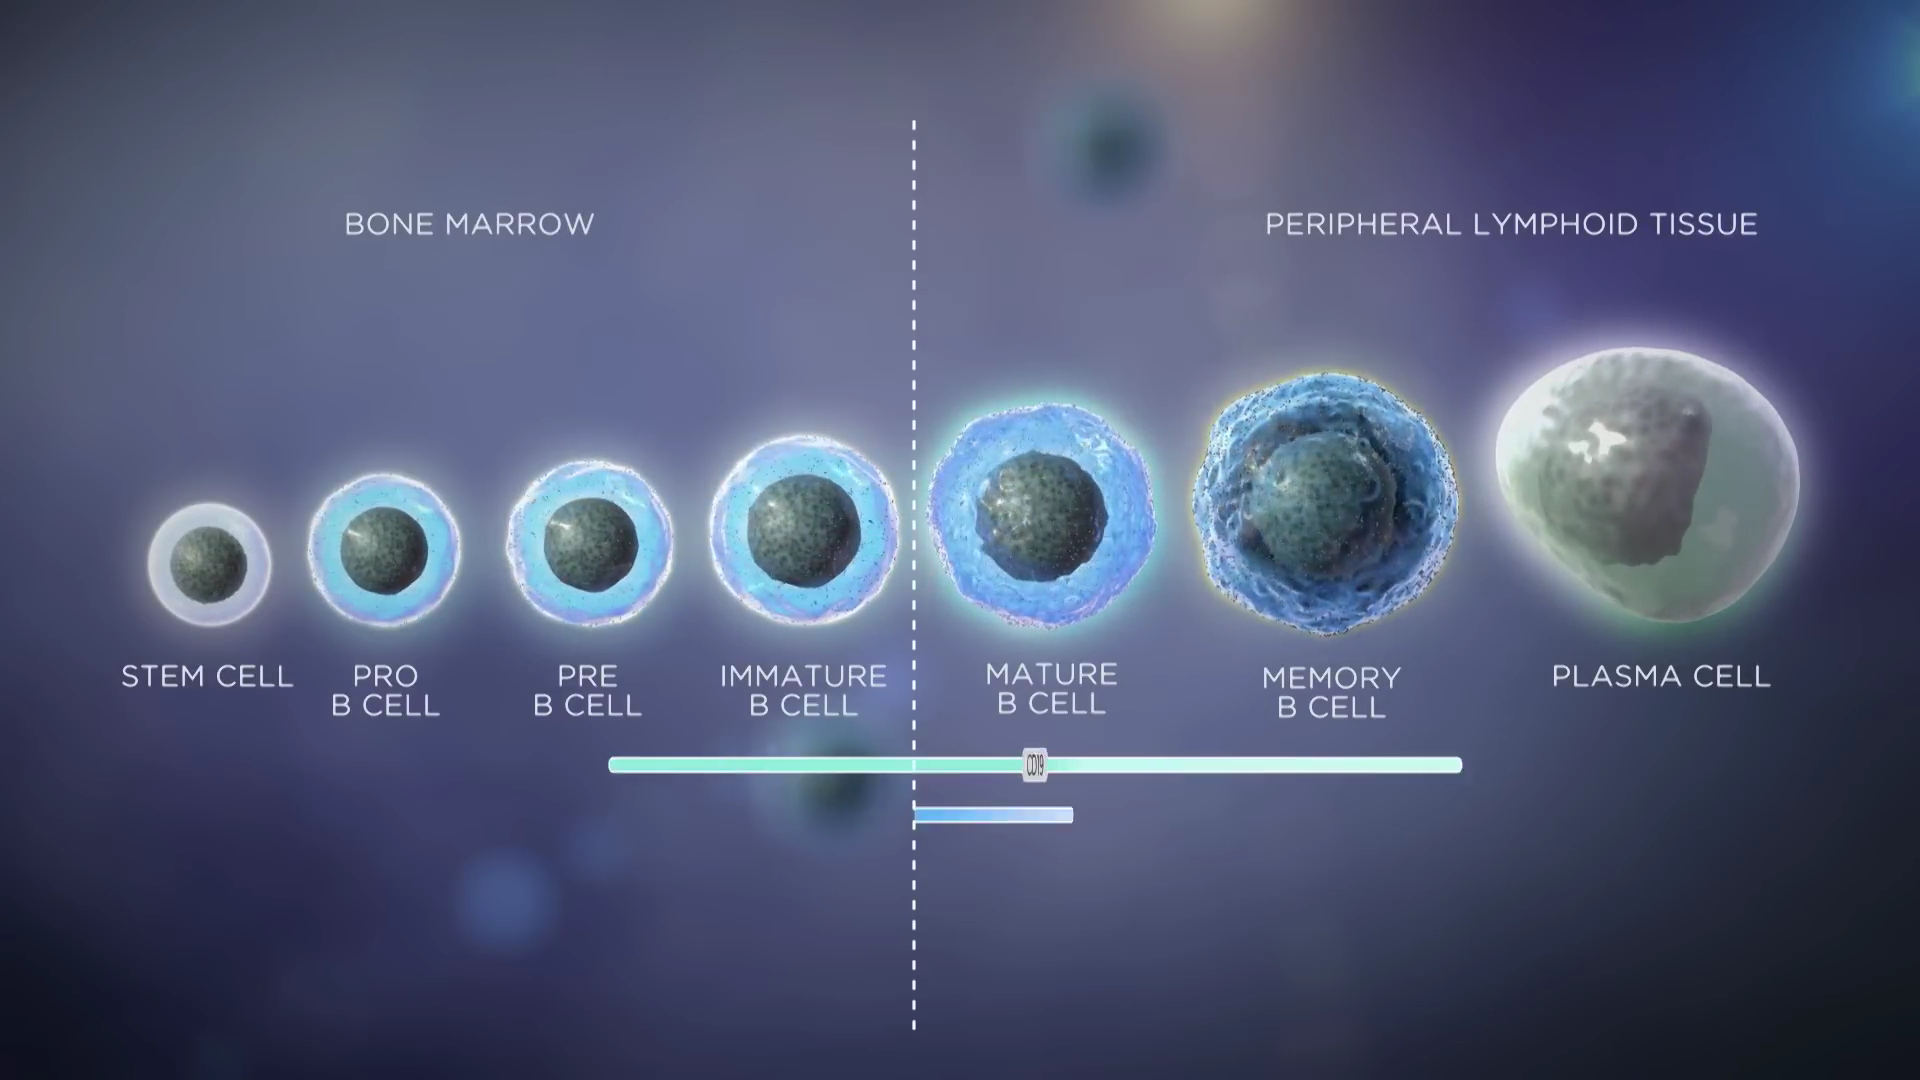

In [18]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [21]:
result, relevant_images = answer("what are the problems experience by the person suffering from multiple sclerosis and provide images related to this")
print(result)

 Multiple sclerosis (MS) is a chronic autoimmune disease that affects the central nervous system, which includes the brain and spinal cord. The symptoms of MS can vary greatly from person to person, depending on the location and extent of the damage in the central nervous system. Some common problems experienced by people with MS include:

1. Vision problems - Optic neuritis, which is inflammation of the optic nerve, can cause vision loss, blurriness, or other visual disturbances.
2. Muscle weakness and spasticity - Damage to the motor nerves in the brain and spinal cord can result in muscle weakness, stiffness, and spasms. This can make it difficult to walk, use your hands, or perform daily activities.
3. Balance and coordination issues - Damage to the cerebellum, which is located at the base of the brain, can cause problems with balance, coordination, and fine motor skills.
4. Fatigue - People with MS often experience extreme fatigue, which can make it difficult to carry out daily ac

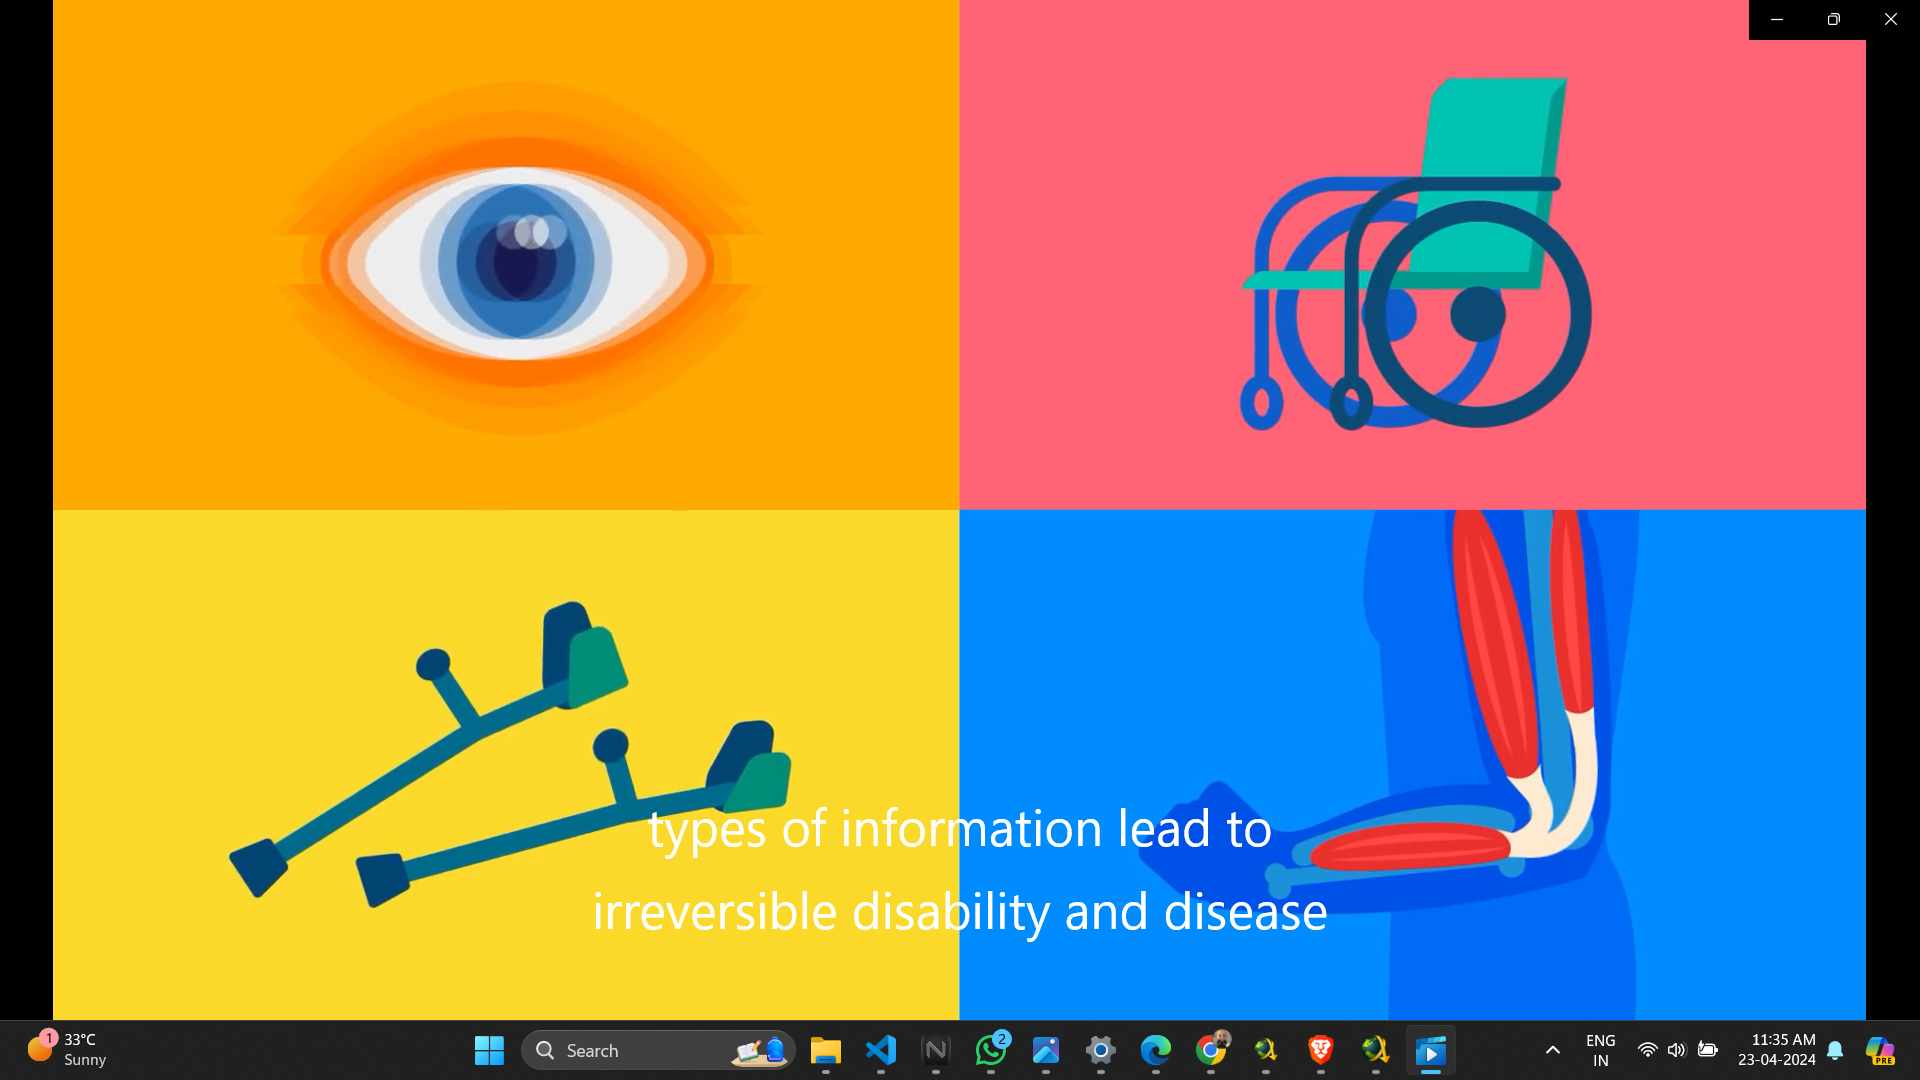

In [25]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [26]:
result, relevant_images = answer("what are the advanced treatment for multiple sclerosis")
print(result)

 Multiple sclerosis (MS) is a chronic autoimmune disorder that affects the central nervous system. Over the past few decades, significant advances have been made in the treatment of MS to help manage its symptoms and slow down its progression. Here are some advanced treatments for MS:

1. Disease-modifying therapies (DMTs): These medications are designed to reduce the frequency and severity of relapses and slow down the progression of disability. Examples include Tysabri, Gilenya, Lemtrada, Ocrevus, Zinbryta, Aubagio, and Teriflunomide.
2. Stem cell therapy: Neural stem cell therapy is a promising area of research that involves infusing neural stem cells into the body to help protect and repair damaged neurons in the brain and spinal cord. Although still in its early stages, this treatment has shown potential benefits for people with progressive MS.
3. Monoclonal antibodies: These are laboratory-produced proteins that can target specific parts of the immune system to help reduce inflam

In [27]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

IndexError: list index out of range

In [28]:
result, relevant_images = answer("what does the AHSCT procedure actually involved")
print(result)

 The AHSCT (Autologous Hematopoietic Stem Cell Transplantation) procedure is a complex medical treatment used to treat certain conditions, including multiple sclerosis (MS). Here's an overview of the six main stages involved in the procedure:

1. Mobilization: This stage involves taking medications to encourage your stem cells to move from your bone marrow into your bloodstream, making them easier to collect. The drugs used include cyclophosphamide and G-CSF. During this phase, you may experience worsening MS symptoms.
2. Stem cell collection (harvesting): Once enough stem cells have been mobilized into your bloodstream, they are collected using a machine that separates the stem cells from other components of your blood. This process can take half a day to one day.
3. Conditioning: After your stem cells have been collected, you will undergo chemotherapy (high-dose methotrexate or busulfan) and possibly total body irradiation to prepare your body for the transplant. These treatments des

In [30]:
result, relevant_images = answer("exercise routine for MS")
print(result)

 Exercise is an essential component of managing multiple sclerosis (MS) symptoms and improving overall health and well-being. A regular exercise routine can help improve muscle strength, flexibility, balance, coordination, and cardiovascular fitness while reducing fatigue, stress, and anxiety. Here are some recommended exercises for individuals with MS:

1. Aerobic Exercises: These activities increase heart rate and breathing, improving cardiovascular health. Examples include brisk walking, cycling, swimming, or using an elliptical machine. Aim for at least 150 minutes of moderate-intensity aerobic activity per week.

2. Resistance Training: Strengthening exercises help maintain muscle mass and improve overall strength. Use bodyweight exercises, resistance bands, or free weights to target major muscle groups. Perform 2-3 sets of 8-12 repetitions for each exercise, 2-3 days per week.

3. Flexibility Exercises: Stretching helps maintain range of motion and prevent contractures. Focus on 

In [31]:
result, relevant_images = answer("explain and provide me the image of B-cell")
print(result)

 A B cell is a type of white blood cell that plays a crucial role in the adaptive immune response by producing antibodies against specific antigens. Antibodies are proteins produced by the immune system to neutralize or eliminate pathogens, such as bacteria and viruses, from the body.

B cells originate from hematopoietic stem cells in the bone marrow and develop into mature B cells through a process called B cell differentiation. When a B cell encounters an antigen, it becomes activated and undergoes clonal expansion, resulting in the production of large numbers of identical B cells that secrete the same type of antibody. These antibodies bind to the antigen, marking it for destruction by other immune cells or neutralizing its effects.

B cells can be further classified into two main types based on their surface receptors: naive B cells and memory B cells. Naive B cells are found in the bone marrow and lymph nodes and have not yet encountered their specific antigen. Memory B cells, on

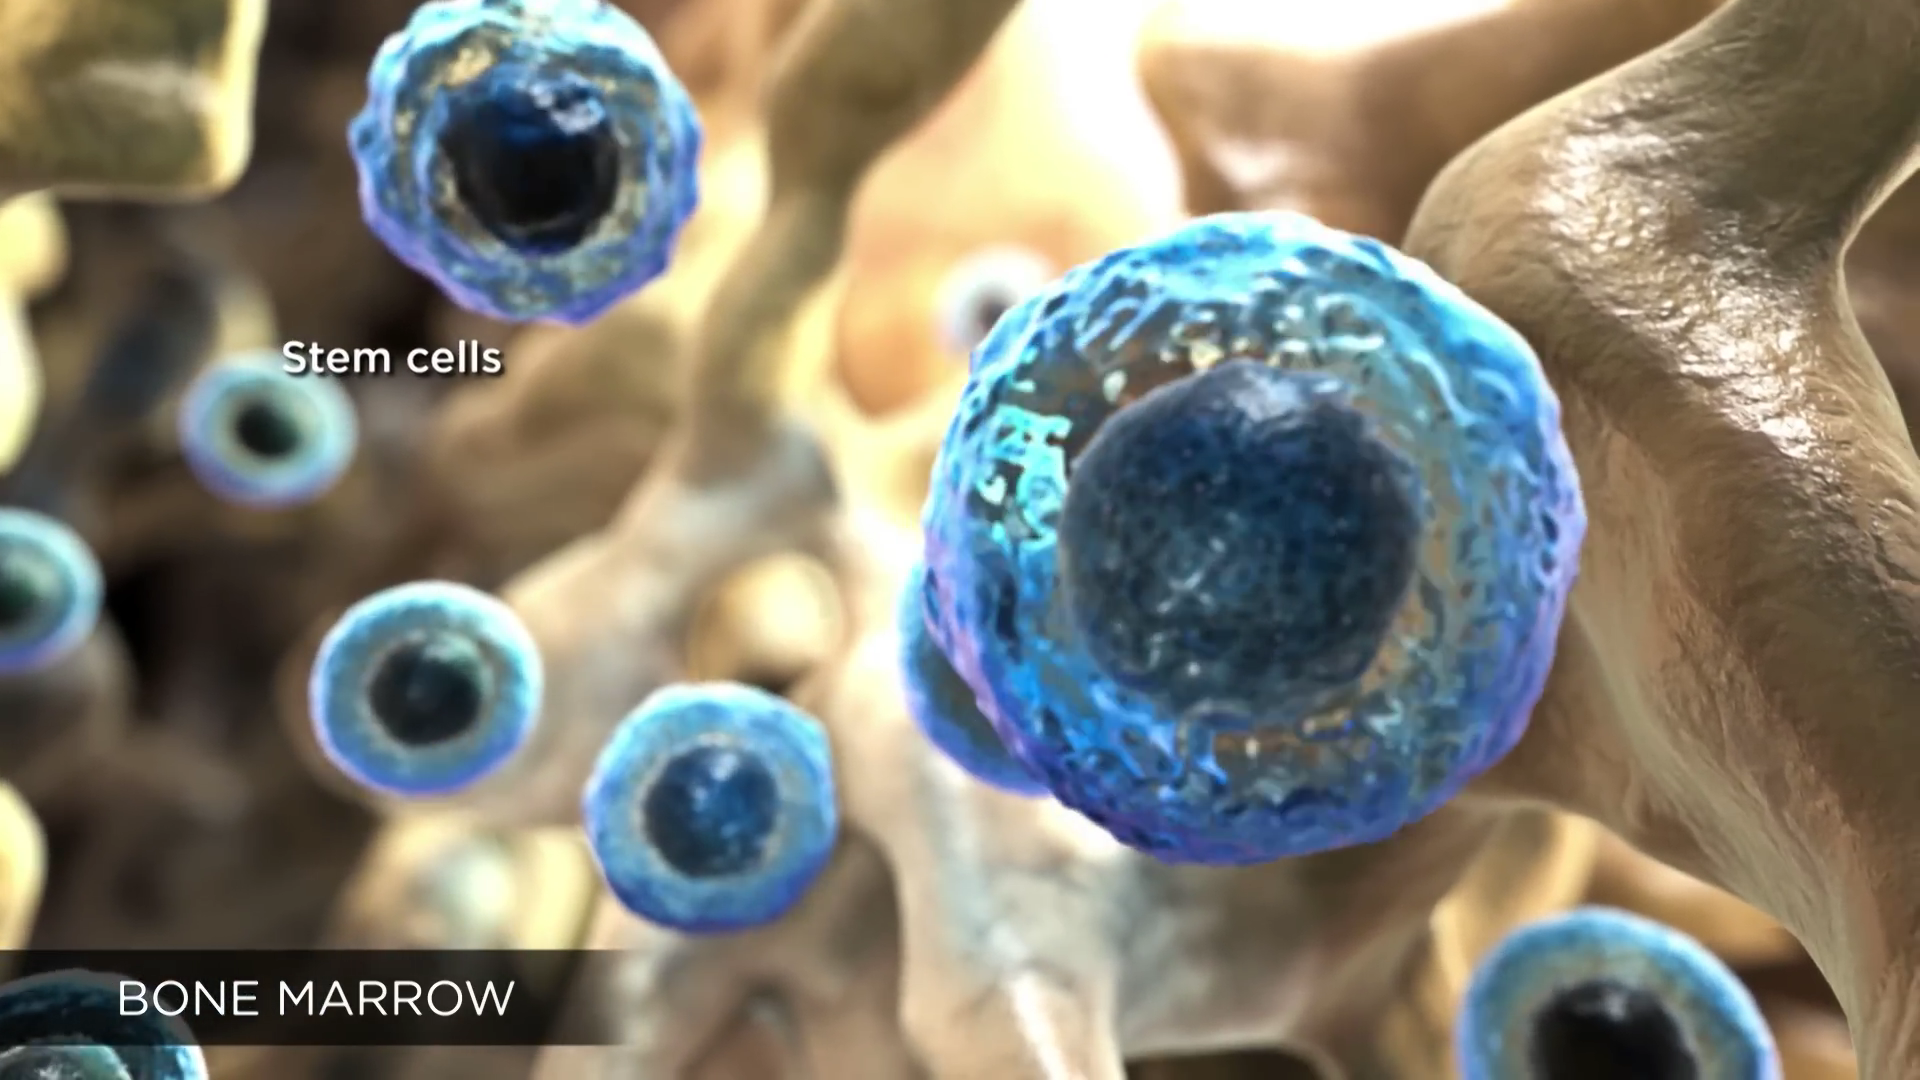

In [35]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [36]:
result, relevant_images = answer("intravenous infusion medication")
print(result)

 An intravenous (IV) infusion is a method of administering medication directly into a vein. This type of treatment is typically given in a clinical setting, such as a hospital or infusion center. Infusions can be used to deliver a variety of medications, including disease-modifying therapies (DMTs) for multiple sclerosis (MS).

Infusion treatments include:

1. DISEASE-MODIFYING THERAPIES (DMTs): These medications are designed to slow the progression of MS and reduce the frequency and severity of relapses. Examples include:
* NATALIZUMAB (TYSABRI) - Benefit: works by targeting specific immune cells, has been shown to reduce the number of relapses in people with RRMS. Dose frequency: every 4 weeks, intravenous infusion for 30 minutes. Common side effects can include: headache, fatigue, and rash. Warnings include: increased risk of progressive multifocal leukoencephalopathy (PML), a rare but serious brain infection.
* MITXOFOLINE (MAVENCLAD) - Benefit: works by selectively depleting certa

In [37]:
result, relevant_images = answer("what causes exacerbations?")
print(result)

 Exact causes of MS exacerbations or relapses are not fully understood yet. However, research suggests that various factors may contribute to the worsening of symptoms during an MS flare-up. These include:

1. Immune system activity: MS is considered an autoimmune disease, meaning the immune system mistakenly attacks the protective covering of nerve fibers in the central nervous system (CNS), leading to communication problems between the brain and the rest of the body. During an exacerbation, there may be increased immune cell activity that damages more nerve tissue.
2. Infections: Viral or bacterial infections can trigger an MS relapse by stimulating the immune response. Commonly implicated viruses include Epstein-Barr virus and John Cunningham virus.
3. Stress: Emotional stress can worsen symptoms in some people with MS, potentially contributing to exacerbations.
4. Environmental factors: Exposure to extreme temperatures, particularly cold weather, may trigger MS relapses for some in

In [38]:
db.similarity_search("what causes exacerbations?")

[Document(page_content=" This text summarizes various studies and reports related to Multiple Sclerosis (MS). Santra and Ray identified the first case of Marburg's variant of MS. Dudani, Pandit, and other researchers studied the relationship between vitamin D levels and MS. Mycophenolate mofetil was found useful in treating MS by Pandit et al. Singhal et al. reported clinical details of MS patients from a northern tertiary center. Malli et al. identified measles, vegetarian diet, higher educational status, and urban living as risk factors for MS while Helicobacter pylori infection was protective. Chinnadurai et al. suggested cognitive fatigue in patients with MS and showed that P13, N10, and P37 latencies strongly predicted falls in patients with MS. Bansil et al. conducted a case-control study of environmental exposures to MS in India. Singh et al. used magnetic resonance imaging to differentiate between acute disseminated encephalomyelitis and MS. Narayan et al. reported a case serie

In [39]:
vec=db.as_retriever()

In [40]:
vec.invoke("what causes exacerbations?")

[Document(page_content=" This text summarizes various studies and reports related to Multiple Sclerosis (MS). Santra and Ray identified the first case of Marburg's variant of MS. Dudani, Pandit, and other researchers studied the relationship between vitamin D levels and MS. Mycophenolate mofetil was found useful in treating MS by Pandit et al. Singhal et al. reported clinical details of MS patients from a northern tertiary center. Malli et al. identified measles, vegetarian diet, higher educational status, and urban living as risk factors for MS while Helicobacter pylori infection was protective. Chinnadurai et al. suggested cognitive fatigue in patients with MS and showed that P13, N10, and P37 latencies strongly predicted falls in patients with MS. Bansil et al. conducted a case-control study of environmental exposures to MS in India. Singh et al. used magnetic resonance imaging to differentiate between acute disseminated encephalomyelitis and MS. Narayan et al. reported a case serie